# Проект с использованием BERT
<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Необходимо обучить модель классифицировать комментарии на позитивные и негативные. В распоряжении набор данных с разметкой о токсичности правок.

Нужно построить модель со значением метрики качества *F1* не меньше 0.75. 


**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
!pip install catboost
# !pip3 install emoji==0.6.0

In [1]:
import catboost
import csv
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import transformers
from tqdm import notebook
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import f1_score, make_scorer
from sklearn.utils import shuffle

In [2]:
R_STATE = 12345

In [4]:
#по какой-то причине при стандартном открытии файла токенайзер выдавал ошибку, это исправление подглядел на StackOverflow
with open('toxic_comments.csv', encoding='utf-8') as file:
    reader = csv.DictReader(file)
    data = pd.DataFrame(reader)
data.info()
data.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0           159292 non-null  object
 1   text    159292 non-null  object
 2   toxic   159292 non-null  object
dtypes: object(3)
memory usage: 3.6+ MB


,,text,toxic
7932,7944,", 11 January 2007 (UTC)\n\n Don't worry. I'm ...",0
136508,136646,Yes. I know about the two options of 'l'/'L' s...,0
32155,32195,"""\n\nPlease tell me where the """"personal attac...",0
24347,24367,hey tard. \n\nthe purpose of that section was ...,0
129726,129859,mr joustra said protrusion rebels were in char...,0
157554,157713,"Hm...sorry to butt in, but following this logi...",0
117507,117606,"Kangaroo, wallaroo and wallaby have the same p...",0
144983,145139,India quick links \n\n | talk,0
106166,106263,"""\n\nSpeedy deletion of Dead squirrel\n Please...",0
17668,17685,I apologized to terry \n\nSo please stop bothe...,0


Для выполнения работы есть база данных с почти 160 тысячами записей. Это потребует масштабных вычислений, для чего уместно задействовать видеокарту.

In [5]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

False

In [6]:
data[data['text'].duplicated()].sum()

         0.0
text     0.0
toxic    0.0
dtype: float64

Дубликатов в базе нет. Теперь нужно конвертировать целевой признак в число.

In [7]:
data['toxic'] = data['toxic'].astype('int')
data['toxic']

0         0
1         0
2         0
3         0
4         0
         ..
159287    0
159288    0
159289    0
159290    0
159291    0
Name: toxic, Length: 159292, dtype: int64

Время посмотреть на баланс классов целевого признака.

0    143106
1     16186
Name: toxic, dtype: int64

Токсичных твитов меньше нейтральных в 8.841344371679229 раз


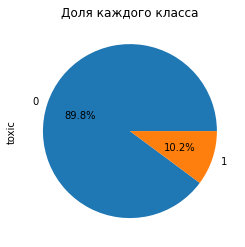

In [8]:
display(data['toxic'].value_counts())
diff = len(data.loc[data['toxic']==0, 'toxic']) / len(data.loc[data['toxic']==1, 'toxic'])
print('Токсичных твитов меньше нейтральных в', diff , 'раз')
data['toxic'].value_counts().plot(kind='pie', autopct='%1.1f%%', grid=True, title='Доля каждого класса');

Классы несбалансированы, и в идеальной ситуации стоит их сбалансировать. Однако ни апсемплинг, ни даунсемплинг не подходят - в качестве данных не простые числа, а текст, несущий смысловую нагрузку, поэтому и случайное удаление, и увеличение числа вхождения случайных текстов внесут существенные изменения - поэтому нужно просто учесть несбалансированность классов при обучении модели.

Дальше будет конвертация текста в массив векторов.

In [9]:
data_X = data['text']
data_y = data['toxic']

In [10]:
tokenizer = transformers.BertTokenizerFast.from_pretrained('unitary/toxic-bert', do_lower_case=True)

tokenized = data_X.apply(
    lambda x: tokenizer.encode(x, truncation=True, add_special_tokens=True))

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

In [11]:
model = transformers.BertModel.from_pretrained('unitary/toxic-bert', output_hidden_states=False).to(DEVICE)

In [12]:
batch_size = 99 #это делитель, дающий наименьший остаток
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]).to(DEVICE)
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)]).to(DEVICE)
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())

  0%|          | 0/1609 [00:00<?, ?it/s]

In [13]:
features = np.concatenate(embeddings)

In [14]:
features

array([[-0.55851054, -1.0476656 ,  0.7199496 , ..., -0.71159095,
         0.5249055 ,  0.11277001],
       [-0.5933712 , -0.99813044,  0.6239391 , ..., -0.69221944,
         0.46335796,  0.10821172],
       [-0.61220884, -0.865758  ,  0.74858934, ..., -0.6126192 ,
         0.50902766,  0.13732645],
       ...,
       [-0.4192744 , -0.41037002,  0.18284497, ..., -0.5108813 ,
         0.587998  ,  0.56956494],
       [-0.6624775 , -0.76997966,  0.6595743 , ..., -0.8293034 ,
         0.60107785,  0.3854629 ],
       [-0.43634877, -0.7622255 ,  0.8043335 , ..., -0.67769533,
         0.6962611 ,  0.26211855]], dtype=float32)

In [15]:
#этот блок кода нужен для сохранения промежуточных результатов, т.к. токенайзер слишком долго считает, 
#а catboost имеет обыкновение убивать ядро при использовании для вычислений видеокарту.

#pd.DataFrame(features).to_csv('features') 
#features = pd.read_csv('features') 
features = pd.DataFrame(features)

### Обучение

Массив целевого признака нужно обрезать на единичку, т.к. один из текстов был обрезан при кодировке.
Х и у будут использованы для gridsearch, train и valid для стандартного подбора гиперпараметров

In [16]:
data_y = data_y[:-1]
X, test_X, y, test_y = train_test_split(features, data_y, test_size=0.2)
train_X, valid_X, train_y, valid_y = train_test_split(X, y,
                                                    test_size=0.25)


Стоит проконтролировать, что пропорции дисбаланса для разбиения примерно равны пропорциям дисбаланса исходного датасета.

toxic
0    114472
1     12960
Name: count, dtype: int64

Токсичных твитов меньше нейтральных в 8.832716049382716 раз


toxic
0    85858
1     9716
Name: count, dtype: int64

Токсичных твитов меньше нейтральных в 8.83676410045286 раз


toxic
0    28633
1     3226
Name: count, dtype: int64

Токсичных твитов меньше нейтральных в 8.87569745815251 раз


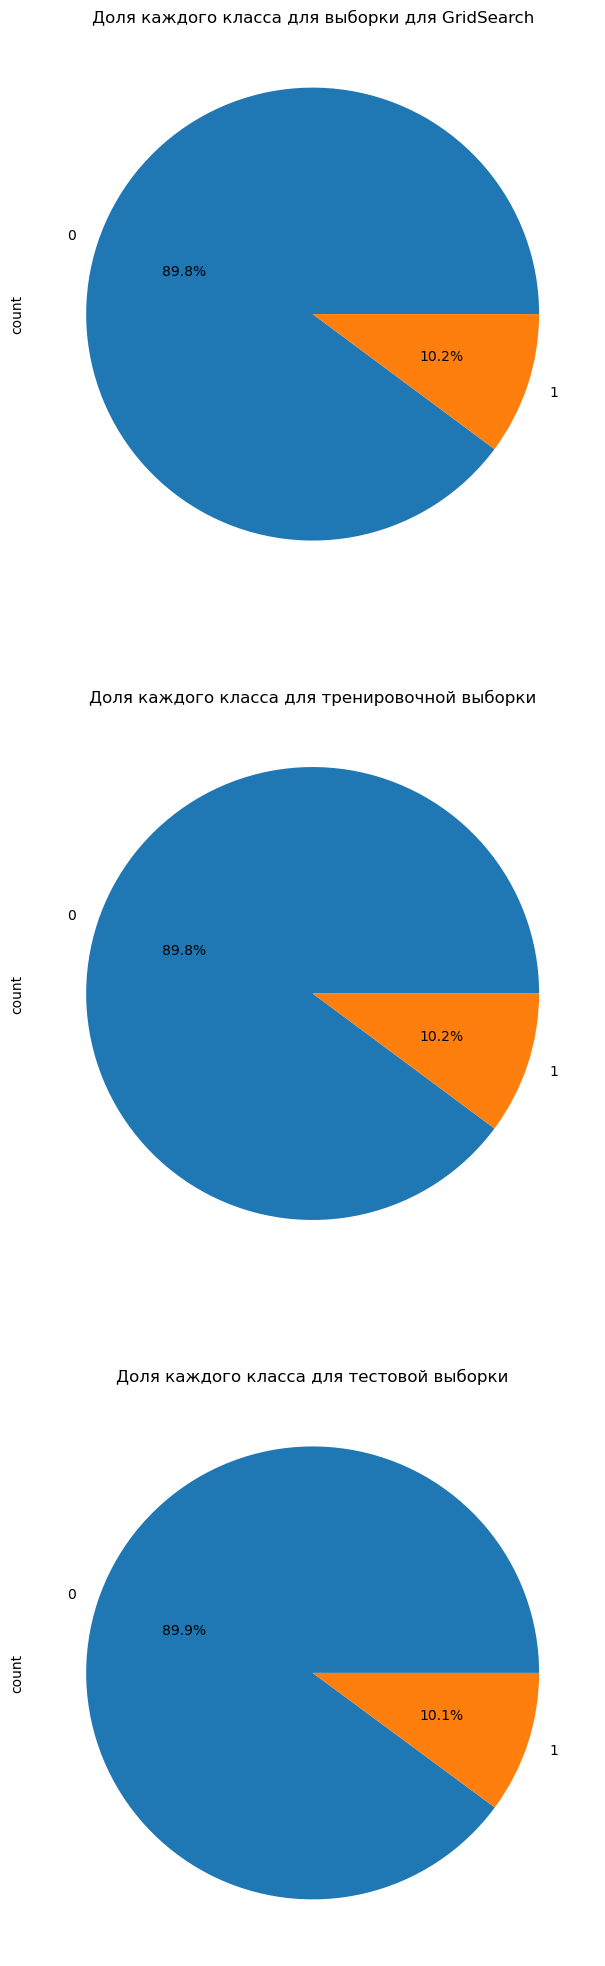

In [17]:
titles = ['выборки для GridSearch', 'тренировочной выборки', 'тестовой выборки']
k = 0
plt.figure(figsize=(15, 25))
for data_y in [y, train_y, test_y]:
    display(data_y.value_counts())
    diff = len(data_y.иloc[data_y==0]) / len(data_y.loc[data_y==1])
    print('Токсичных твитов меньше нейтральных в', diff , 'раз')
    plt.subplot(3, 1, k+1)
    data_y.value_counts().plot(kind='pie', autopct='%1.1f%%', grid=True, title='Доля каждого класса для '+titles[k]);
    k += 1

Первая модель - логистическая регрессия. Потенциально будет долго считаться, т.к. массив признаков занимает 1.3 гигабайта, а процедуры матричного умножения и в особенности поиска обратной матрицы довольно ресурсоёмкие.

In [18]:
%%time
param_grid = {'C': [0.1, 1, 10]}
model_lr = LogisticRegression(random_state=R_STATE, max_iter=5000, class_weight='balanced')
grid_lr = GridSearchCV(model_lr, param_grid=param_grid, scoring='f1', cv=5, return_train_score=True)
grid_lr.fit(X, y)
print('Лучший результат для линейной регрессии - ' , grid_lr.best_score_)
print('Этот результат получен со следующими параметрами:' , grid_lr.best_params_)

Лучший результат для линейной регрессии -  0.9259499907669021
Этот результат получен со следующими параметрами: {'C': 1}
CPU times: total: 1h 3min 11s
Wall time: 12min 2s


Логистическая регрессия сразу же показала отличный результат, однако для поиска оптимальной модели стоит задействовать и другие.

Следующая - классификатор, основанный на решающих деревьях.

In [19]:
%%time
best_model_dct = None
best_result = 0
best_depth = 0
for depth in range(1, 21, 2):
    model = DecisionTreeClassifier(random_state=R_STATE, max_depth=depth, class_weight='balanced')
    model.fit(train_X, train_y)
    predictions = model.predict(valid_X)
    result = f1_score(predictions, valid_y)
    if result > best_result:
        best_model_dct = model
        best_result = result
        best_depth = depth

print("F1 score лучшей модели DecisionTreeClassifier:", best_result)
print("Значение параметра depth для лучшей модели DecisionTreeClassifier:", best_depth)

F1 score лучшей модели DecisionTreeClassifier: 0.9269027882441596
Значение параметра depth для лучшей модели DecisionTreeClassifier: 19
CPU times: total: 32min 9s
Wall time: 32min 50s


Схожий с логистической регрессией итоговый показатель, но обучилась она быстрее, да и предсказывать потенциально так же должна быстрее.

Следующие модели основаны на бустинге - это CatBoost и LightGBM

In [20]:
%%time
cat_cat = catboost.CatBoostClassifier(random_state=R_STATE, auto_class_weights='Balanced', eval_metric='TotalF1', 
                                      logging_level='Silent')
grid_cbc = {'learning_rate': [0.05, 0.1],
           'depth': [4, 8]}
grid_catboost = cat_cat.grid_search(grid_cbc, X=X, y=y)
print('Лучший результат для CatBoostClassifier - ', f1_score(cat_cat.predict(valid_X), valid_y))
print('Он получен со следующими параметрами - ' , grid_catboost['params'])

0:	loss: 0.9845310	best: 0.9845310 (0)	total: 44.7s	remaining: 2m 14s
1:	loss: 0.9838640	best: 0.9845310 (0)	total: 1m 27s	remaining: 1m 27s
2:	loss: 0.9843441	best: 0.9845310 (0)	total: 4m 47s	remaining: 1m 35s
3:	loss: 0.9839410	best: 0.9845310 (0)	total: 8m 5s	remaining: 0us
Estimating final quality...
Лучший результат для CatBoostClassifier -  0.954753131908622
Он получен со следующими параметрами -  {'depth': 4, 'learning_rate': 0.05}
CPU times: total: 1h 14min 9s
Wall time: 11min


Более высокий показатель метрики дался высокой ценой - несмотря на то, что теоретически алгоритм должен обучаться быстрее, фактически он учился дольше логистической регрессии, хотя и параметров для поиска по сетке тут было больше.

In [21]:
%%time
best_model_lgb = None
best_n_estimators = None
best_max_bin = None
best_f1_lgb = 0
for n_estimators in [750, 1000]:
    for max_bin in [100, 200]:
        booster = lgb.LGBMClassifier(objective="binary", class_weight='balanced', n_estimators=n_estimators, 
                                device_type='gpu', max_bin=max_bin, random_state=R_STATE)
        booster.fit(train_X, train_y, eval_metric='f1')
        predictions = booster.predict(valid_X)
        result = f1_score(booster.predict(valid_X), valid_y)
        if result > best_f1_lgb:
            best_n_estimators = n_estimators
            best_model_lgb = booster
            best_max_bin = max_bin
            best_f1_lgb = result    
print("F1 score лучшей модели LGBMModel:", best_f1_lgb)
print("Значение параметров n_estimators и max_bin для лучшей модели LGBMModel:", best_n_estimators, best_max_bin)

[LightGBM] [Info] Number of positive: 9716, number of negative: 85858
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 76800
[LightGBM] [Info] Number of data points in the train set: 95574, number of used features: 768
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 768 dense feature groups (70.00 MB) transferred to GPU in 0.024891 secs. 0 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 9716, number of negative: 85858
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 153600
[LightGBM] [Info] Number of data points in the train set: 95574, number of used features: 768
[LightGBM] [

Судя по всему, перед нами победитель - минимальное время обучения, хотя и слегка уступает CatBoost'у по итоговому показателю f1.
Т.к. в итоге были получены близкие показатели метрики, для проверке на тесте будут использованы обе модели.

In [23]:
print('F1 score для CatBoostClassifier равен', f1_score(test_y, cat_cat.predict(test_X)))
print('F1 score для LGBMModel равен', f1_score(test_y, best_model_lgb.predict(test_X)))

F1 score для CatBoostClassifier равен 0.9334516415261757
F1 score для LGBMModel равен 0.9466093893832463


На тесте LightGBM показал лучший результат, что с учётом более быстрого обучения окончательно ставит точку в ответе на вопрос о лучшей модели.

## Выводы

Для выполнения задания был изучен датасет текстов, из которых почти 90% имели нейтральный характер, а остальные - токсичный. Для построения модели была задействована нейросеть Bert, предобученная как раз для поиска токсичных комментариев (unitary/toxic-bert). Это предопределило итоговый результат - все модели показали достойный показатель f1 score, от 0,92 до 0,95 на тренировочной выборке, выделенной из основного датасета.

Были обучены следующие модели:
- LogisticRegression позволила добиться показателя 0.926 с гиперпараметром C = 1
- DecisionTreeClassifier показала 0.927 с depth =19
- CatBoostClassifier показал наивысший результат - 0.955 - на обучении с depth = 4 и learning_rate = 0.05
- LGBMClassifier обучилась быстрее всех (меньше чем за 10 минут) с n_estimators = 1000 и max_bin = 100, f1 score = 0.943

Последние 2 модели показали сходные результаты и были протестированы на тестовой выборке. LGBMClassifier показала наилучший результат, который превзошёл её же показатель на трейне - 0.946 - и именно эта модель рекомендуется для использования в целях классификации комментариев на позитивные и негативные.